# 1) Feature Selection

## a) Load Libraries & Datasets

In [1]:
!pip install darts
!pip install shap

In [2]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
%matplotlib inline

import shap
import pickle
import random
import tensorflow as tf
from scipy.interpolate import interp1d
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from pytorch_lightning.callbacks import Callback
from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, Add, GlobalAveragePooling1D, MultiHeadAttention, Conv1D


from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.utils.timeseries_generation import (gaussian_timeseries, linear_timeseries, sine_timeseries)
from darts.models import (RNNModel, TCNModel, TransformerModel, NBEATSModel, TFTModel, XGBModel)
from darts.metrics import mape, rmse, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import logging
logging.disable(logging.CRITICAL)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

df_bbca = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BBCA.csv')
df_bbni = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BBNI.csv')
df_bbri = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BBRI.csv')
df_bmri = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_BMRI.csv')
df_mega = pd.read_csv('/content/drive/MyDrive/SKRIPSI/df/df_MEGA.csv')

# Define datasets
dfs = [df_bbca, df_bbni, df_bbri, df_bmri, df_mega]
labels = ['BBCA', 'BBNI', 'BBRI', 'BMRI', 'MEGA']
labels_c0 = ['BBCA', 'BBNI', 'BMRI']
labels_c1 = ['BBRI', 'MEGA']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## b) Feature Selection using Shapley

In [4]:
def compute_shapley_importances_lstm(df, drop_cols=['Date']):
    random.seed(1)
    np.random.seed(1)
    tf.random.set_seed(1)

    # Scale the entire dataset
    scaler = MinMaxScaler()
    df_temp = df.drop(columns=drop_cols)
    scaled_data = scaler.fit_transform(df_temp)

    # Convert to DataFrame for convenience
    scaled_df = pd.DataFrame(scaled_data, columns=df_temp.columns)

    # Define target (Close) and features
    target = 'Close'
    features = [col for col in scaled_df.columns if col != target]
    X = scaled_df[features].values
    y = scaled_df[target].values

    # Create sequences for time-series modeling
    def create_sequences(X, y, seq_length):
        X_seq, y_seq = [], []
        for i in range(len(X) - seq_length):
            X_seq.append(X[i:i+seq_length])
            y_seq.append(y[i+seq_length])
        return np.array(X_seq), np.array(y_seq)

    SEQ_LENGTH = 24  # Example: 24 time steps
    X_seq, y_seq = create_sequences(X, y, SEQ_LENGTH)

    # Train-Test split while preserving temporal order
    train_size = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]

    # Define the LSTM model with 3 layers and 1 dropout layer
    model = Sequential([
        LSTM(20, activation='relu', input_shape=(SEQ_LENGTH, len(features))),
        Dense(1)  # Predicting the 'Close' price
    ])

    # Compile and train the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=0)

    # Reshape X_test to 2D for SHAP
    X_test_2d = X_test.reshape(X_test.shape[0], -1)[:10]  # Flatten sequences
    X_train_2d = X_train.reshape(X_train.shape[0], -1)[:100]

    # Adjust SHAP for the model
    def predict_fn(X):
        X_reshaped = X.reshape(X.shape[0], SEQ_LENGTH, len(features))  # Reshape back for the model
        return model.predict(X_reshaped).flatten()

    explainer = shap.KernelExplainer(predict_fn, X_train_2d)  # Use subset for efficiency
    shap_values = explainer.shap_values(X_test_2d)  # Subset for SHAP computation

    # Aggregate mean absolute Shapley values per feature
    feature_importances = pd.DataFrame({
        'Feature': features * SEQ_LENGTH,  # Repeat features for all time steps
        'Importance': np.mean(np.abs(shap_values), axis=0)
    })
    return feature_importances

In [5]:
# USING LSTM

# Compute Shapley values for all datasets and combine into a single DataFrame
all_importances = []
for df, label in zip(dfs, labels):
    importances = compute_shapley_importances_lstm(df)
    importances = importances.rename(columns={'Importance': label})
    importances = importances.set_index('Feature')
    all_importances.append(importances)

# Combine all importances into a single DataFrame
combined_importances = pd.concat(all_importances, axis=1)
combined_importances = combined_importances.groupby('Feature').mean()
combined_importances['Average (Cluster 0)'] = abs(combined_importances[['BBCA','BBNI','BMRI']].mean(axis=1))
combined_importances['Average (Cluster 1)'] = abs(combined_importances[['BBRI','MEGA']].mean(axis=1))
combined_importances.reset_index(inplace=True)
combined_importances

Feature      BBCA      BBNI      BBRI      BMRI      MEGA  \
0                 DER  0.009742  0.005627  0.003120  0.000000  0.000000   
1                 EPS  0.004663  0.004443  0.014728  0.010196  0.003634   
2                 FAT  0.002771  0.001481  0.005515  0.002079  0.002431   
3                 PBV  0.005714  0.001841  0.005208  0.002809  0.001572   
4                 PER  0.003916  0.002083  0.021290  0.002324  0.000968   
5                 PTS  0.016355  0.006688  0.021086  0.003191  0.002860   
6                ROA%  0.005101  0.004546  0.016456  0.002827  0.002575   
7                ROE%  0.018585  0.006045  0.011501  0.008298  0.001288   
8    is_first_2_weeks  0.002434  0.000492  0.007339  0.001575  0.002473   
9       is_idul_fitri  0.002837  0.001180  0.002974  0.003133  0.002780   
10  is_ramadhan_start  0.002450  0.001272  0.003923  0.002335  0.000823   

    Average (Cluster 0)  Average (Cluster 1)  
0              0.005123             0.001560  
1              0.006434             0.009181  
2              0.002110             0.003973  
3              0.003455             0.003390  
4              0.002774             0.011129  
5              0.008745             0.011973  
6              0.004158             0.009515  
7              0.010976             0.006395  
8              0.001500             0.004906  
9              0.002383             0.002877  
10             0.002019             0.002373

Selected Features for Cluster 0: ['ROE%' 'PTS' 'EPS' 'DER'], Threshold: 0.00452
Selected Features for Cluster 1: ['PTS' 'PER' 'ROA%' 'EPS' 'ROE%'], Threshold: 0.00612


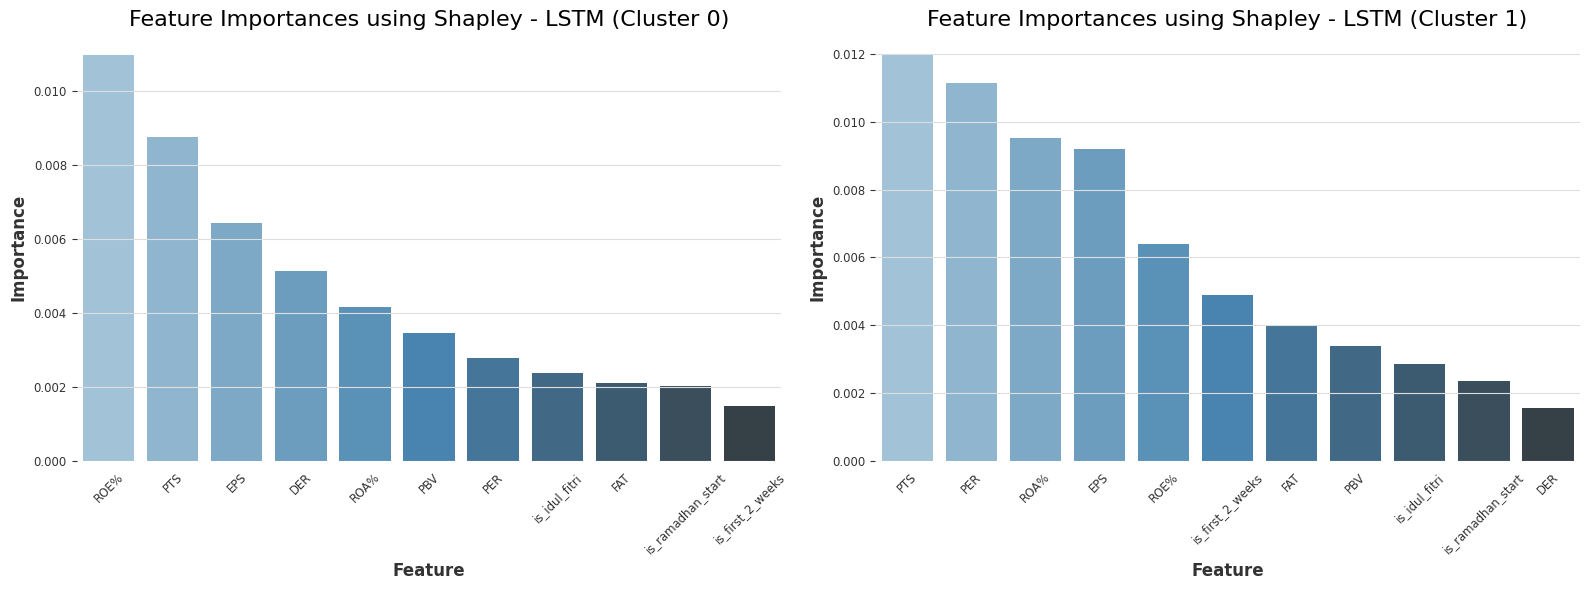

In [6]:
df_sorted = combined_importances.sort_values(by="Average (Cluster 0)", ascending=False).reset_index(drop=True)
threshold_c0 = df_sorted['Average (Cluster 0)'].mean()
selected_features_c0 = df_sorted[df_sorted['Average (Cluster 0)'] > threshold_c0]['Feature'].values

df_sorted = combined_importances.sort_values(by="Average (Cluster 1)", ascending=False).reset_index(drop=True)
threshold_c1 = df_sorted['Average (Cluster 1)'].mean()
selected_features_c1 = df_sorted[df_sorted['Average (Cluster 1)'] > threshold_c1]['Feature'].values

print(f'Selected Features for Cluster 0: {selected_features_c0}, Threshold: {round(threshold_c0, 5)}')
print(f'Selected Features for Cluster 1: {selected_features_c1}, Threshold: {round(threshold_c1, 5)}')


# Create a figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Feature Importances - Average (Cluster 0)
temp = combined_importances.sort_values(by='Average (Cluster 0)', ascending=False)
sns.barplot(x='Feature', y='Average (Cluster 0)', data=temp, palette="Blues_d", ax=axes[0])
axes[0].set_title("Feature Importances using Shapley - LSTM (Cluster 0)", fontsize=16)
axes[0].set_xlabel("Feature", fontsize=12)
axes[0].set_ylabel("Importance", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Feature Importances - Average (Cluster 1)
temp = combined_importances.sort_values(by='Average (Cluster 1)', ascending=False)
sns.barplot(x='Feature', y='Average (Cluster 1)', data=temp, palette="Blues_d", ax=axes[1])
axes[1].set_title("Feature Importances using Shapley - LSTM (Cluster 1)", fontsize=16)
axes[1].set_xlabel("Feature", fontsize=12)
axes[1].set_ylabel("Importance", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between plots
plt.tight_layout()

# Show combined plot
plt.show()

# 2) Data Preprocessing

In [7]:
def data_preprocessing(df, columns):
    # Convert all variables to TimeSeries format
    price = TimeSeries.from_values(df['Close'])
    time_series_data = {col: TimeSeries.from_values(df[col]) for col in columns}

    # Stack the fundamental data to obtain series of 2 dimensions
    covariates = time_series_data[columns[0]]  # Start with 'PER' as the base
    for col in columns[1:]:  # Skip the first column since it's already included
        covariates = covariates.stack(time_series_data[col])

    # Split the covariates into training and validation sets
    train_covariates, val_covariates = covariates[:-split], covariates[-split:]

    # Scale the covariates between 0 and 1
    scaler_covariates = Scaler()
    train_covariates = scaler_covariates.fit_transform(train_covariates)
    val_covariates = scaler_covariates.transform(val_covariates)

    # Concatenate the scaled results for model input
    covariates = concatenate([train_covariates, val_covariates])

    # Scale the price data
    scaler_price = Scaler()
    price_scaled = scaler_price.fit_transform(price)
    train_df, val_df = price_scaled[:-split], price_scaled[-split:]

    return train_df, val_df, covariates, scaler_price, price_scaled

In [8]:
split = 36 # splitting point (prediksi 36 minggu ke depan)

fund_columns_all = ['PER', 'FAT', 'PTS', 'EPS', 'PBV', 'DER', 'ROE%', 'ROA%', 'is_first_2_weeks', 'is_idul_fitri', 'is_ramadhan_start']
fund_columns_c0 = ['PTS', 'EPS', 'DER', 'ROE%']
fund_columns_c1 = ['PER', 'PTS', 'EPS', 'ROE%', 'ROA%']

In [9]:
train_bbca, val_bbca, covariates_bbca, scaler_bbca, price_bbca = data_preprocessing(df_bbca, fund_columns_c0)
train_bbni, val_bbni, covariates_bbni, scaler_bbni, price_bbni = data_preprocessing(df_bbni, fund_columns_c0)
train_bbri, val_bbri, covariates_bbri, scaler_bbri, price_bbri = data_preprocessing(df_bbri, fund_columns_c1)
train_bmri, val_bmri, covariates_bmri, scaler_bmri, price_bmri = data_preprocessing(df_bmri, fund_columns_c0)
train_mega, val_mega, covariates_mega, scaler_mega, price_mega = data_preprocessing(df_mega, fund_columns_c1)

train_lists_c0 = [train_bbca, train_bbni, train_bmri]
val_lists_c0 = [val_bbca, val_bbni, val_bmri]
covariates_lists_c0 = [covariates_bbca, covariates_bbni, covariates_bmri]
scalers_lists_c0 = [scaler_bbca, scaler_bbni, scaler_bmri]
price_lists_c0 = [price_bbca, price_bbni, price_bmri]
df_lists_c0 = [df_bbca, df_bbni, df_bmri]

train_lists_c1 = [train_bbri, train_mega]
val_lists_c1 = [val_bbri, val_mega]
covariates_lists_c1 = [covariates_bbri, covariates_mega]
scalers_lists_c1 = [scaler_bbri, scaler_mega]
price_lists_c1 = [price_bbri, price_mega]
df_lists_c1 = [df_bbri, df_mega]

In [10]:
train_bbca, val_bbca, covariates_bbca, scaler_bbca, price_bbca = data_preprocessing(df_bbca, fund_columns_all)
train_bbni, val_bbni, covariates_bbni, scaler_bbni, price_bbni = data_preprocessing(df_bbni, fund_columns_all)
train_bbri, val_bbri, covariates_bbri, scaler_bbri, price_bbri = data_preprocessing(df_bbri, fund_columns_all)
train_bmri, val_bmri, covariates_bmri, scaler_bmri, price_bmri = data_preprocessing(df_bmri, fund_columns_all)
train_mega, val_mega, covariates_mega, scaler_mega, price_mega = data_preprocessing(df_mega, fund_columns_all)

train_lists_c0_all = [train_bbca, train_bbni, train_bmri]
val_lists_c0_all = [val_bbca, val_bbni, val_bmri]
covariates_lists_c0_all = [covariates_bbca, covariates_bbni, covariates_bmri]
scalers_lists_c0_all = [scaler_bbca, scaler_bbni, scaler_bmri]
price_lists_c0_all = [price_bbca, price_bbni, price_bmri]
df_lists_c0_all = [df_bbca, df_bbni, df_bmri]

train_lists_c1_all = [train_bbri, train_mega]
val_lists_c1_all = [val_bbri, val_mega]
covariates_lists_c1_all = [covariates_bbri, covariates_mega]
scalers_lists_c1_all = [scaler_bbri, scaler_mega]
price_lists_c1_all = [price_bbri, price_mega]
df_lists_c1_all = [df_bbri, df_mega]

# 3) Modeling

## a) Define Functions

In [11]:
# predict model using future covariates
def predict_futcov(train_data, val_data, model, scaler, stock_name, covariates, df, model_name):
    pred_cov = model.predict(n=36, series=train_data, future_covariates=covariates) # Prediction 36 timestamps forward from the last training data
    pred_cov_inverse = scaler.inverse_transform(pred_cov) # Inverse transform the scaled data
    val_inverse = scaler.inverse_transform(val_data)

    # Plot the actual and predicted values
    plt.figure(figsize=(7, 4))
    plt.plot(pd.to_datetime(df['Date']), df['Close'], label="actual")
    plt.plot(pd.to_datetime(df['Date'][-len(pred_cov_inverse):]), pred_cov_inverse.values(), label="forecast")

    # Add legend and labels
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Stock Price')

    # Calculate metrics: MAPE, MAE, RMSE
    mape_score = round(mape(val_inverse, pred_cov_inverse), 2)
    mae_score = round(mae(val_inverse, pred_cov_inverse), 2)
    rmse_score = round(rmse(val_inverse, pred_cov_inverse), 2)

    # Display the metrics in the title
    plt.title(f'{stock_name} - {model_name}\nMAPE = {mape_score}%, MAE = {mae_score}, RMSE = {rmse_score}')
    plt.show()

In [12]:
# predict model using no covariates
def predict_nocov(train_data, val_data, model, scaler, stock_name, df, model_name):
    pred_cov = model.predict(n=36, series=train_data) # Prediction 36 timestamps forward from the last training data
    pred_cov_inverse = scaler.inverse_transform(pred_cov) # Inverse transform the scaled data
    val_inverse = scaler.inverse_transform(val_data)

    # Plot the actual and predicted values
    plt.figure(figsize=(7, 4))
    plt.plot(pd.to_datetime(df['Date']), df['Close'], label="actual")
    plt.plot(pd.to_datetime(df['Date'][-len(pred_cov_inverse):]), pred_cov_inverse.values(), label="forecast")

    # Add legend and labels
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Stock Price')

    # Calculate metrics: MAPE, MAE, RMSE
    mape_score = round(mape(val_inverse, pred_cov_inverse), 2)
    mae_score = round(mae(val_inverse, pred_cov_inverse), 2)
    rmse_score = round(rmse(val_inverse, pred_cov_inverse), 2)

    # Display the metrics in the title
    plt.title(f'{stock_name} - {model_name}\nMAPE = {mape_score}%, MAE = {mae_score}, RMSE = {rmse_score}')
    plt.show()

In [13]:
# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

## b) Model Training - Cluster 0

#### 1) With All Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

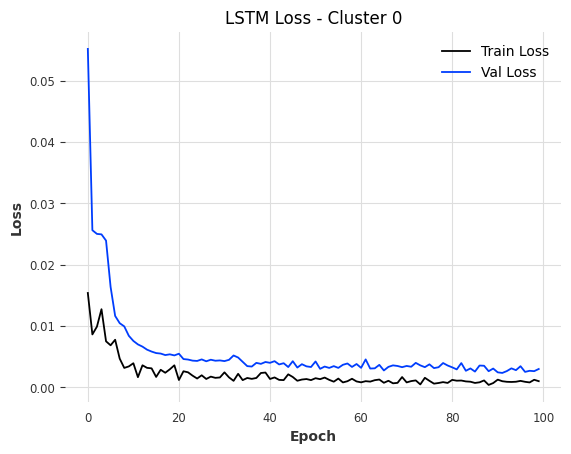

In [14]:
class LossRecorder_lstm(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_lstm = LossRecorder_lstm()

model_name = "LSTM_test"
model_lstm = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    training_length=35,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_lstm]}
    # **generate_torch_kwargs()
)

model_lstm.fit(
    series=train_lists_c0_all,
    future_covariates=covariates_lists_c0_all,
    val_series=val_lists_c0_all,
    val_future_covariates=covariates_lists_c0_all,
)

model_lstm = RNNModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_lstm.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_lstm.val_loss_history, label='Val Loss')
plt.title('LSTM Loss - Cluster 0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
model_lstm

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=35, batch_size=8, n_epochs=100, random_state=1, input_chunk_length=24, output_chunk_length=12, model_name=LSTM_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'callbacks': [<__main__.LossRecorder_lstm object at 0x7fbc9ae366b0>]})

Predicting: |          | 0/? [00:00<?, ?it/s]

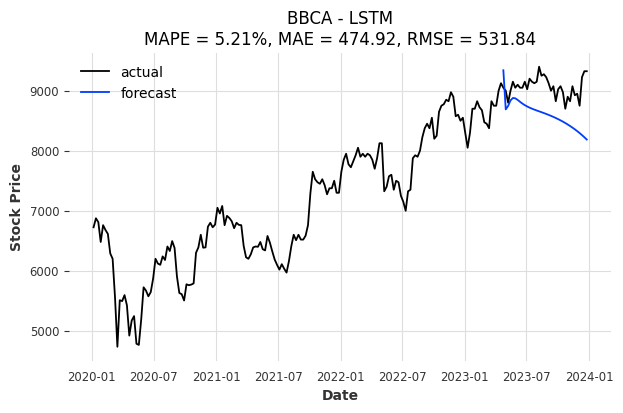

Predicting: |          | 0/? [00:00<?, ?it/s]

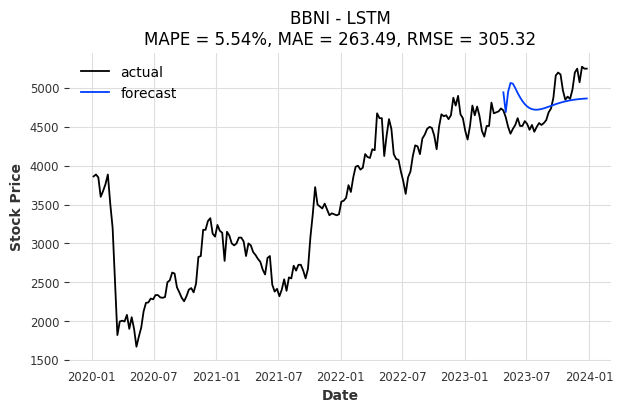

Predicting: |          | 0/? [00:00<?, ?it/s]

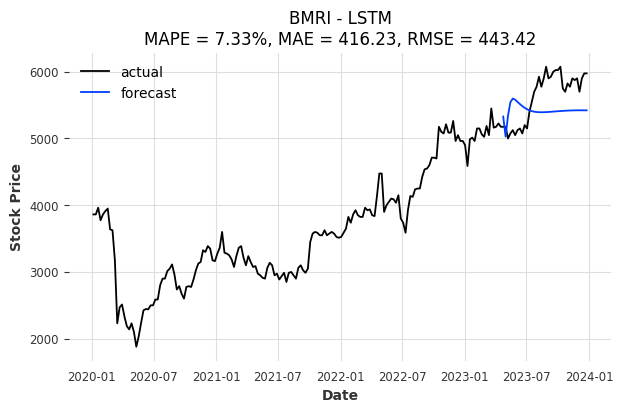

In [16]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c0_all, val_lists_c0_all, scalers_lists_c0_all, labels_c0, covariates_lists_c0_all, df_lists_c0_all):
    predict_futcov(train_data=train, val_data=val,
                   model=model_lstm, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='LSTM')

#### 2) With Shapley Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

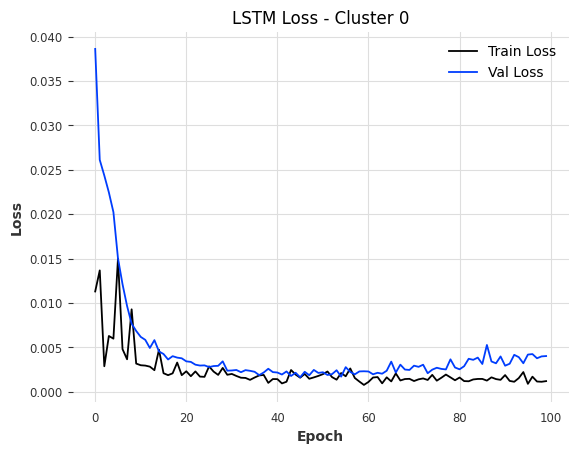

In [17]:
class LossRecorder_lstm(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_lstm = LossRecorder_lstm()

model_name = "LSTM_test"
model_lstm = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    training_length=35,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_lstm]}
    # **generate_torch_kwargs()
)

model_lstm.fit(
    series=train_lists_c0,
    future_covariates=covariates_lists_c0,
    val_series=val_lists_c0,
    val_future_covariates=covariates_lists_c0,
)

model_lstm = RNNModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_lstm.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_lstm.val_loss_history, label='Val Loss')
plt.title('LSTM Loss - Cluster 0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
model_lstm

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=35, batch_size=8, n_epochs=100, random_state=1, input_chunk_length=24, output_chunk_length=12, model_name=LSTM_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'callbacks': [<__main__.LossRecorder_lstm object at 0x7fbc9af7df00>]})

Predicting: |          | 0/? [00:00<?, ?it/s]

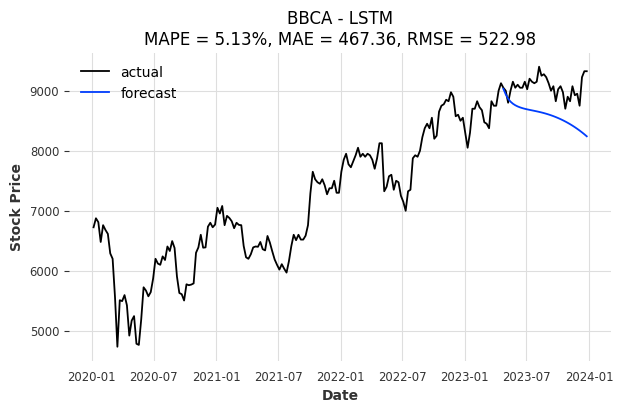

Predicting: |          | 0/? [00:00<?, ?it/s]

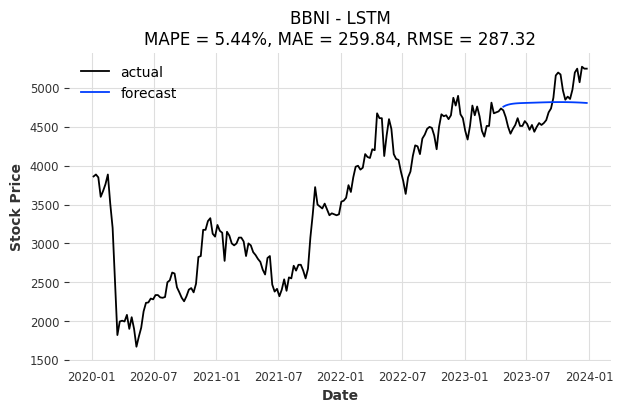

Predicting: |          | 0/? [00:00<?, ?it/s]

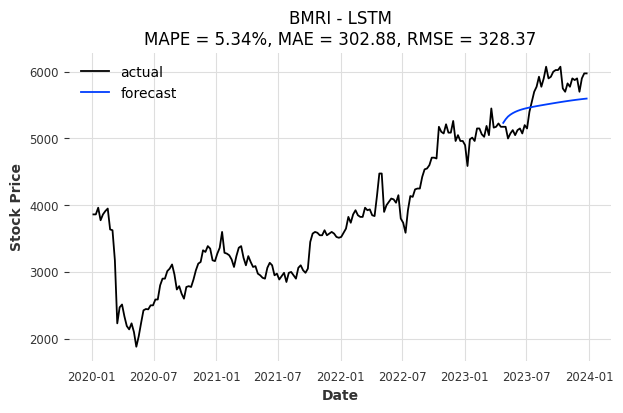

In [19]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c0, val_lists_c0, scalers_lists_c0, labels_c0, covariates_lists_c0, df_lists_c0):
    predict_futcov(train_data=train, val_data=val,
                   model=model_lstm, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='LSTM')

#### 3) No Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

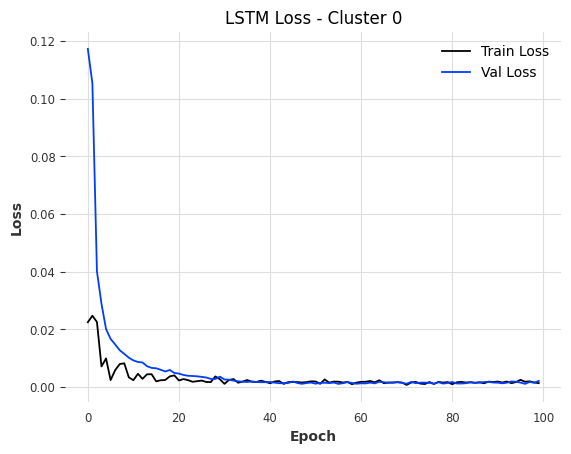

In [20]:
class LossRecorder_lstm(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_lstm = LossRecorder_lstm()

model_name = "LSTM_test"
model_lstm = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    training_length=35,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_lstm]}
    # **generate_torch_kwargs()
)

model_lstm.fit(
    series=train_lists_c0,
    val_series=val_lists_c0,
)

model_lstm = RNNModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_lstm.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_lstm.val_loss_history, label='Val Loss')
plt.title('LSTM Loss - Cluster 0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predicting: |          | 0/? [00:00<?, ?it/s]

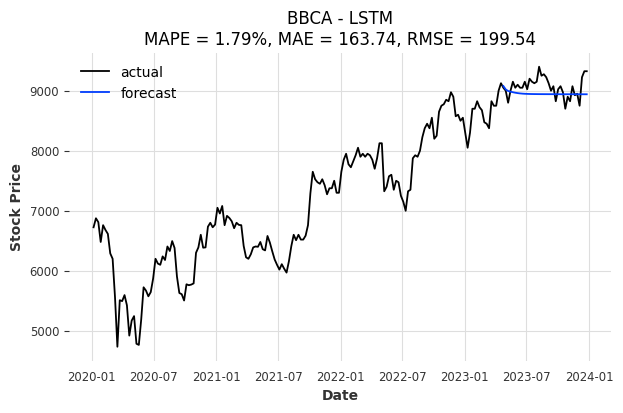

Predicting: |          | 0/? [00:00<?, ?it/s]

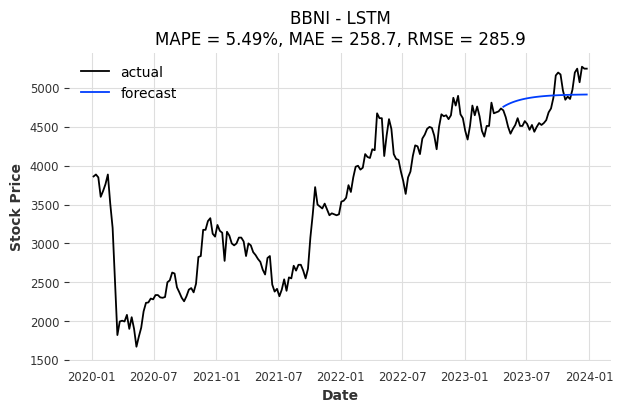

Predicting: |          | 0/? [00:00<?, ?it/s]

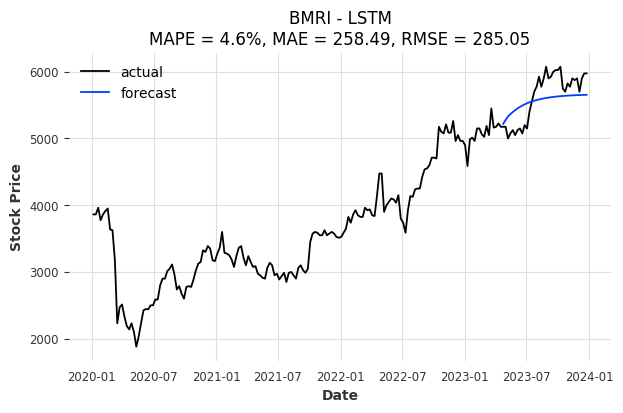

In [21]:
# Loop through the training, validation, and lists
for train, val, scaler, stock, df in zip(train_lists_c0, val_lists_c0, scalers_lists_c0, labels_c0, df_lists_c0):
    predict_nocov(train_data=train, val_data=val,
                   model=model_lstm, scaler=scaler,
                   stock_name=stock, df=df, model_name='LSTM')

## c) Model Training - Cluster 1

#### 1) With All Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

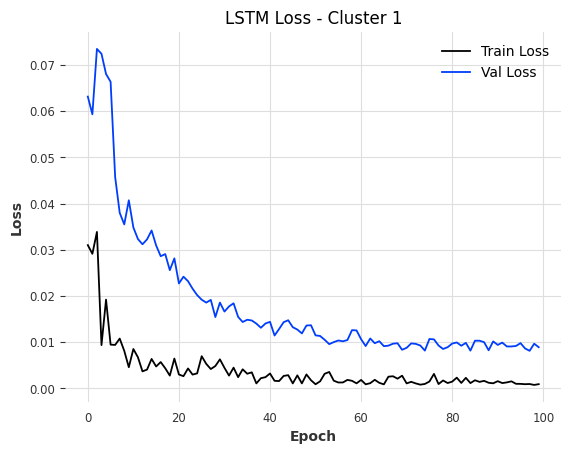

In [23]:
class LossRecorder_lstm(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_lstm = LossRecorder_lstm()

model_name = "LSTM_test"
model_lstm = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    training_length=35,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_lstm]}
    # **generate_torch_kwargs()
)

model_lstm.fit(
    series=train_lists_c1_all,
    future_covariates=covariates_lists_c1_all,
    val_series=val_lists_c1_all,
    val_future_covariates=covariates_lists_c1_all,
)

model_lstm = RNNModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_lstm.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_lstm.val_loss_history, label='Val Loss')
plt.title('LSTM Loss - Cluster 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
model_lstm

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=35, batch_size=8, n_epochs=100, random_state=1, input_chunk_length=24, output_chunk_length=12, model_name=LSTM_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'callbacks': [<__main__.LossRecorder_lstm object at 0x7fbc9a275720>]})

Predicting: |          | 0/? [00:00<?, ?it/s]

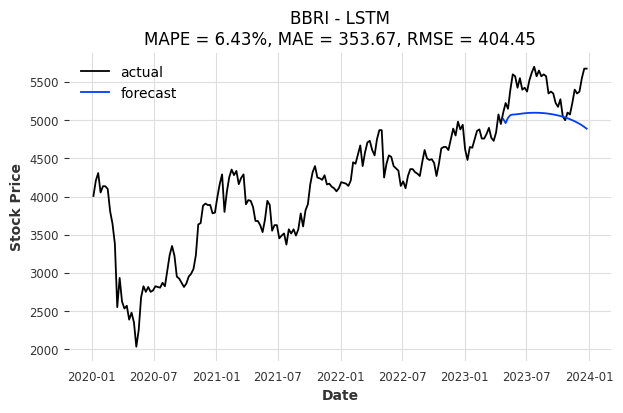

Predicting: |          | 0/? [00:00<?, ?it/s]

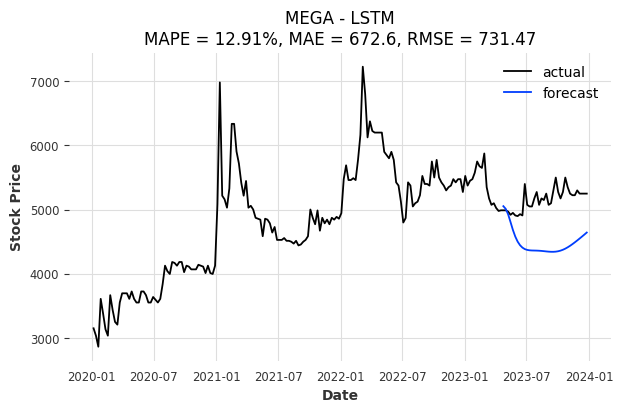

In [25]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c1_all, val_lists_c1_all, scalers_lists_c1_all, labels_c1, covariates_lists_c1_all, df_lists_c1_all):
    predict_futcov(train_data=train, val_data=val,
                   model=model_lstm, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='LSTM')

#### 2) With Shapley Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

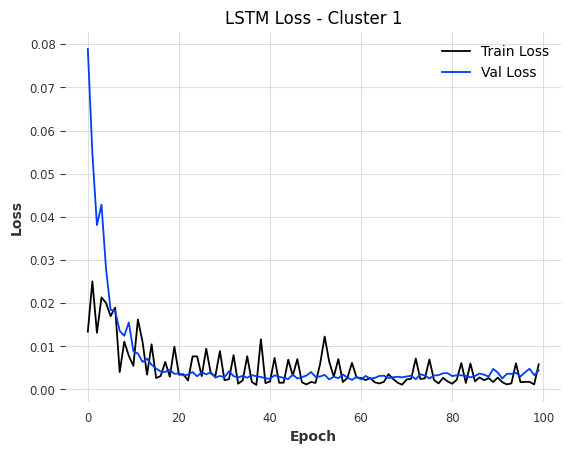

In [26]:
class LossRecorder_lstm(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_lstm = LossRecorder_lstm()

model_name = "LSTM_test"
model_lstm = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    training_length=35,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_lstm]}
    # **generate_torch_kwargs()
)

model_lstm.fit(
    series=train_lists_c1,
    future_covariates=covariates_lists_c1,
    val_series=val_lists_c1,
    val_future_covariates=covariates_lists_c1,
)

model_lstm = RNNModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_lstm.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_lstm.val_loss_history, label='Val Loss')
plt.title('LSTM Loss - Cluster 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
model_lstm

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0.0, training_length=35, batch_size=8, n_epochs=100, random_state=1, input_chunk_length=24, output_chunk_length=12, model_name=LSTM_test, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'callbacks': [<__main__.LossRecorder_lstm object at 0x7fbc99c5e290>]})

Predicting: |          | 0/? [00:00<?, ?it/s]

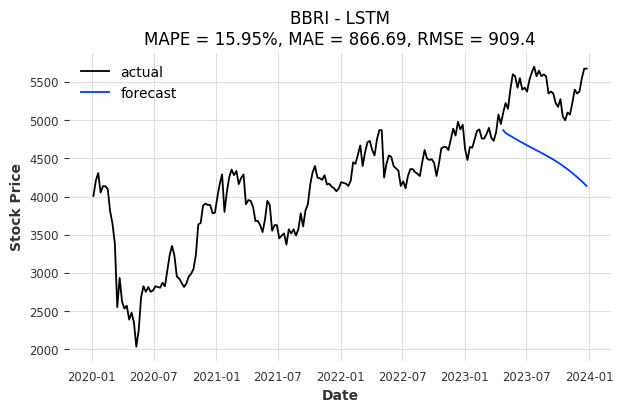

Predicting: |          | 0/? [00:00<?, ?it/s]

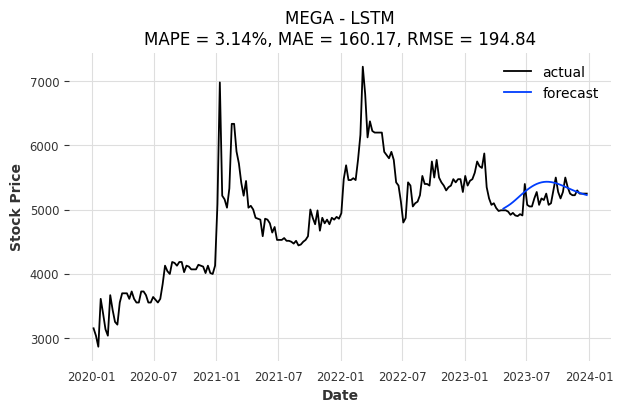

In [28]:
# Loop through the training, validation, and covariate lists
for train, val, scaler, stock, covariate, df in zip(train_lists_c1, val_lists_c1, scalers_lists_c1, labels_c1, covariates_lists_c1, df_lists_c1):
    predict_futcov(train_data=train, val_data=val,
                   model=model_lstm, scaler=scaler,
                   stock_name=stock, covariates=covariate,
                   df=df, model_name='LSTM')

#### 3) No Covariates

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

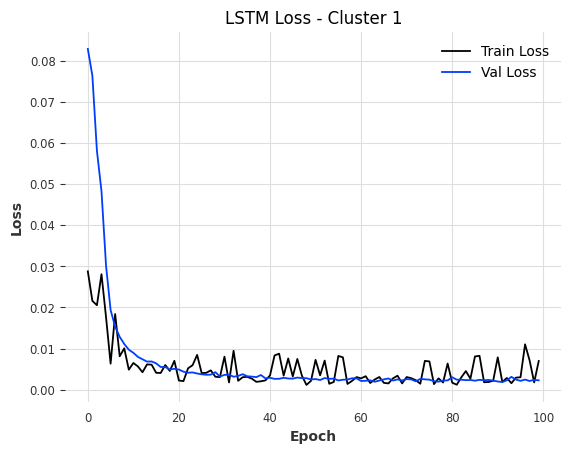

In [29]:
class LossRecorder_lstm(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []
    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())

loss_recorder_lstm = LossRecorder_lstm()

model_name = "LSTM_test"
model_lstm = RNNModel(
    model="LSTM",
    hidden_dim=20,
    batch_size=8,
    n_epochs=100,
    random_state=1,
    training_length=35,
    input_chunk_length=24,
    output_chunk_length=12,
    model_name=model_name,
    save_checkpoints=True,  # store model states: latest and best performing of validation set
    force_reset=True,
    pl_trainer_kwargs={"callbacks": [loss_recorder_lstm]}
    # **generate_torch_kwargs()
)

model_lstm.fit(
    series=train_lists_c1,
    val_series=val_lists_c1,
)

model_lstm = RNNModel.load_from_checkpoint(model_name=model_name, best=True)

plt.plot(loss_recorder_lstm.train_loss_history, label='Train Loss')
plt.plot(loss_recorder_lstm.val_loss_history, label='Val Loss')
plt.title('LSTM Loss - Cluster 1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Predicting: |          | 0/? [00:00<?, ?it/s]

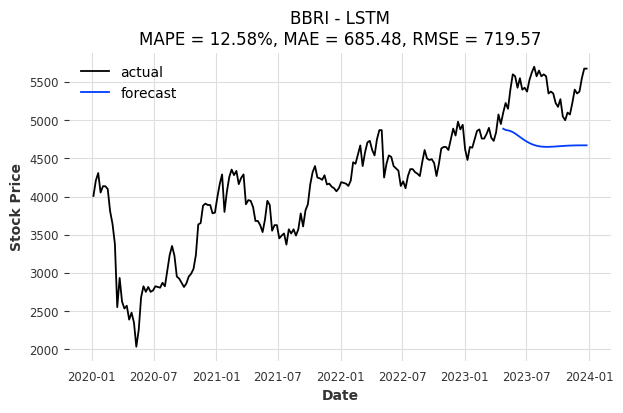

Predicting: |          | 0/? [00:00<?, ?it/s]

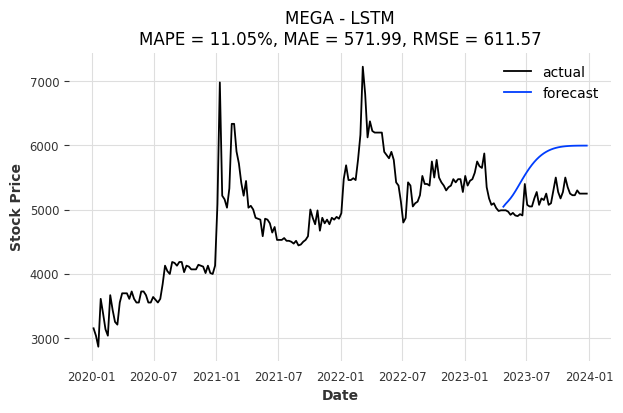

In [30]:
# Loop through the training, validation, and lists
for train, val, scaler, stock, df in zip(train_lists_c1, val_lists_c1, scalers_lists_c1, labels_c1, df_lists_c1):
    predict_nocov(train_data=train, val_data=val,
                   model=model_lstm, scaler=scaler,
                   stock_name=stock, df=df, model_name='LSTM')